# Netflix Classification Project

# ![TLC logo](https://upload.wikimedia.org/wikipedia/commons/thumb/0/08/Netflix_2015_logo.svg/2560px-Netflix_2015_logo.svg.png)

## 1. Imports

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, f1_score
import numpy as np
import seaborn as sns
from pprint import pprint

### Uploading the cleanded dataset

In [2]:
df = pd.read_csv('cleaned_netflix_data.csv')

In [4]:
df.head(5)

,Unnamed: 0,Title,Series or Movie,Runtime,View Rating,IMDb Score,Awards Received,Awards Nominated For,IMDb Votes,Is Nominated,Is Awarded
0,1,Lets Fight Ghost,Series,< 30 minutes,R,7.9,74.0,57.0,205926,1,1
1,2,HOW TO BUILD A GIRL,Movie,1-2 hour,R,5.8,1.0,0.0,2838,0,1
2,3,Centigrade,Movie,1-2 hour,Unrated,4.3,0.0,0.0,1720,0,0
3,4,The Invisible,Movie,1-2 hour,PG-13,6.2,0.0,1.0,34738,1,0
4,5,Joker,Movie,1-2 hour,R,8.4,112.0,228.0,951938,1,1


### Dealing with categorical varibales - Get Dummies & Label Encoder

In [5]:
selected_fetures = df[['Series or Movie','Runtime','IMDb Score','IMDb Votes',
                       'Awards Nominated For']]
X = pd.get_dummies(selected_fetures, drop_first=False)
X = pd.concat([X,df['View Rating']],axis=1)
y = df.iloc[:,-1:]

In [6]:
encoder = LabelEncoder()
encoded = encoder.fit_transform(X['View Rating'])
X['View Rating'] = encoded

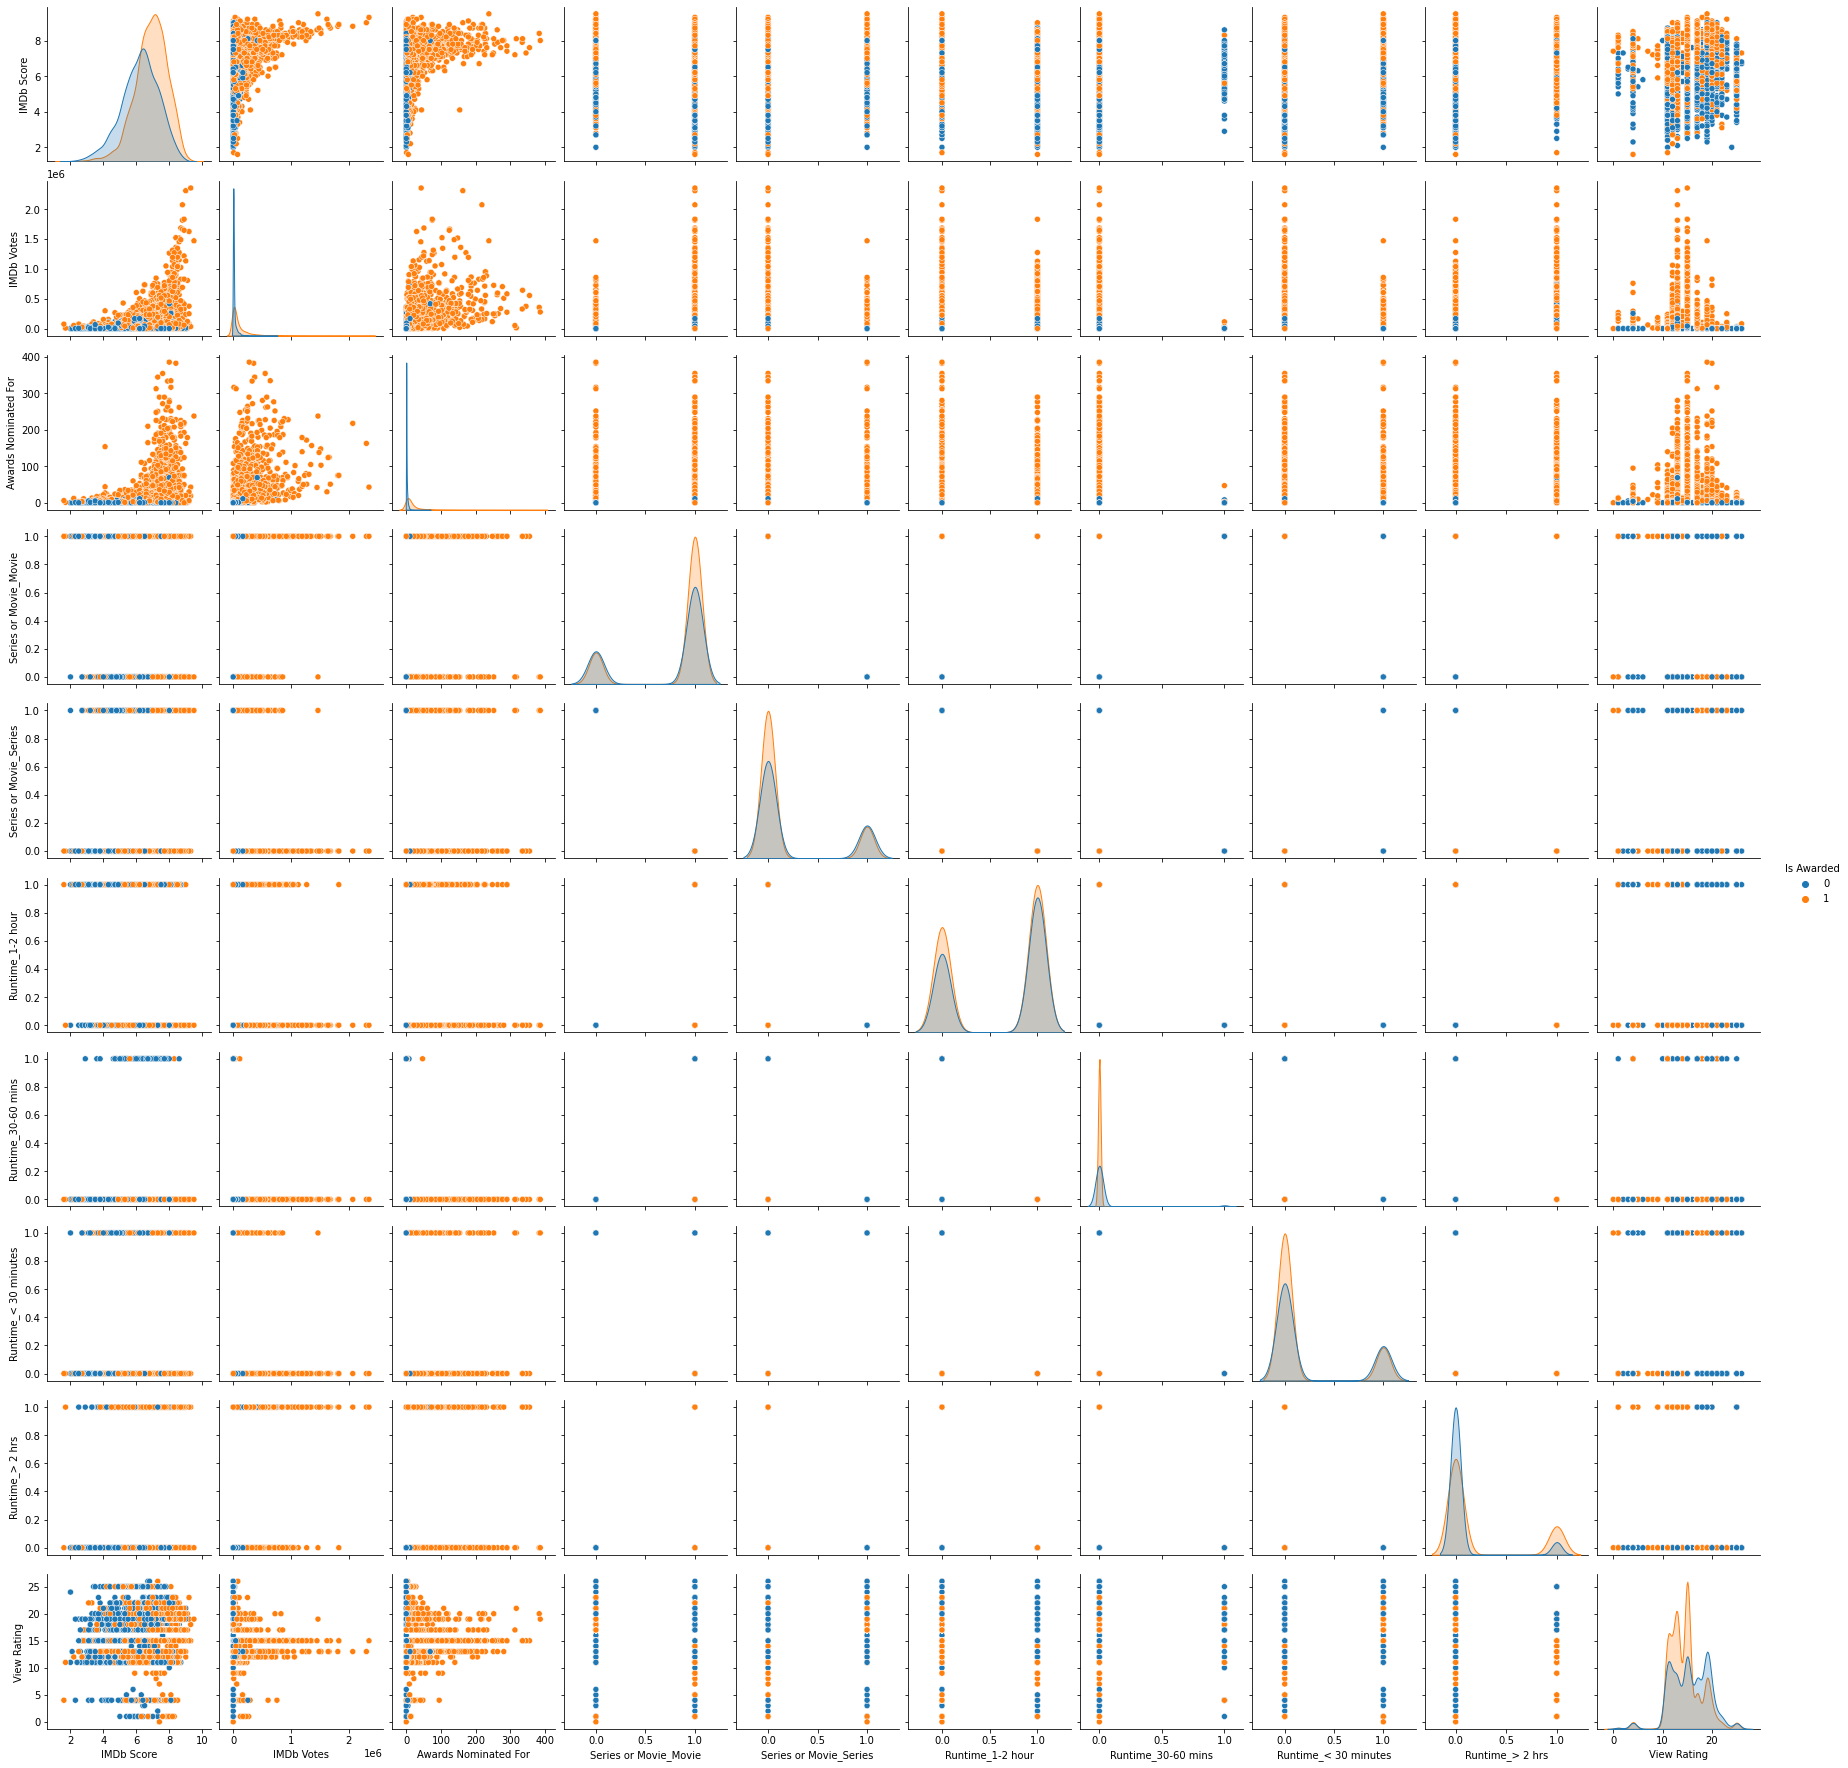

In [7]:
sns.pairplot(pd.concat([X,y],axis=1),hue='Is Awarded')

## 2. Splitting the data - The taget is (Is Awarded)

In [8]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X,y,
                                                            test_size=0.3,random_state=42)
X_train_val, X_test, y_train_val, y_test = X_train_val.reset_index(drop=True),X_test.reset_index(drop=True),y_train_val.reset_index(drop=True),y_test.reset_index(drop=True)

## 3. Scaling 

In [9]:
to_scale = [col for col in X.columns if X[col].max()>1]
sc = StandardScaler()

scaled_train = sc.fit_transform(X_train_val[to_scale])
scaled_train = pd.DataFrame(scaled_train,columns=to_scale)

scaled_test = sc.fit_transform(X_test[to_scale])
scaled_test = pd.DataFrame(scaled_test,columns=to_scale)

for col in scaled_train:
    X_train_val[col] = scaled_train[col]
    X_test[col] = scaled_test[col]

In [10]:
X_train, X_val, y_train, y_val = train_test_split(X_train_val,
                                                  y_train_val,
                                                  test_size=0.2,
                                                  random_state=42)

In [11]:
# checking the balance of the target
y_train['Is Awarded'].value_counts()

1    2571
0    2157
Name: Is Awarded, dtype: int64

## 5. Best Model so far: Random Forest

* ### We check the performance based on F1 score

In [12]:
# define random_grid for tuning
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


In [13]:
# Random Forest Tuning
rf = RandomForestClassifier()
rf_random = RandomizedSearchCV(estimator = rf,
                               param_distributions = random_grid,
                               n_iter = 100, cv = 5, verbose=2,
                               random_state=42, n_jobs = -1)

rf_random.fit(X_train_val, y_train_val)
rf_random.best_params_

Fitting 5 folds for each of 100 candidates, totalling 500 fits


/Users/rawabikhalaf/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:880: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


{'n_estimators': 400,
 'min_samples_split': 10,
 'min_samples_leaf': 4,
 'max_features': 'sqrt',
 'max_depth': 90,
 'bootstrap': True}

In [14]:
# Random Forest with best hyperparameter
# basic fet
rf_best = RandomForestClassifier(n_estimators=400,
                                 min_samples_split=10,
                                 min_samples_leaf=4,
                                 max_features='sqrt',
                                 max_depth=90,
                                 bootstrap=True)
rf_best.fit(X_train, y_train)
y_pred = rf_best.predict(X_val)
y_pred2 = rf_best.predict(X_train)


print("\nDT Accuracy=",accuracy_score(y_val, y_pred))
print("DT F1 score=",f1_score(y_val, y_pred))
print("DT F1 score=",f1_score(y_train, y_pred2))

<ipython-input-14-dd057e1b5dc2>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_best.fit(X_train, y_train)



DT Accuracy= 0.7978003384094755
DT F1 score= 0.804578904333606
DT F1 score= 0.8898938261895399


## Current Findings

* #### The base line model is KNN.
* #### The second model was Decision Tree, and the results were not better.
* #### Then we traied Random Forest, and it gave us the best score so far.